# CAE Classification Experiments #

In [1]:
import datetime
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout, Conv2DTranspose, UpSampling2D
from tensorflow.keras import layers, losses
from tensorflow.keras import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import categorical_crossentropy
from sklearn.model_selection import train_test_split

from utils.get_model import *
from utils.image_formatting import *
from utils.image_scrape import *
tf.random.set_seed(1234)

We load the data

In [2]:
X, y = preprocess_images(artists=['pablo-picasso', 'william-turner', 'claude-monet'], n_imgs=100)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3)
X_train = apply_dropout(X_train, dropout_rate=0)

print(f'X_train: {X_train.shape}')
print(f'y_train: {y_train.shape}\n')
print(f'X_val: {X_val.shape}')
print(f'y_val: {y_val.shape}')

pablo-picasso
william-turner
claude-monet
X_train: (210, 256, 256, 3)
y_train: (210,)

X_val: (90, 256, 256, 3)
y_val: (90,)


We load the latest model

In [3]:
# Get the latest autoencoder model
latest_model = get_latest_model()
latest_model_id = latest_model.split('_')[-1]  # For logging
print(f'Latest model ID: {latest_model_id}')

# Load autoencoder
autoencoder = tf.keras.models.load_model(latest_model)
autoencoder.summary()

Latest model ID: 2021-04-23-21-10
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv2D_1 (Conv2D)            (None, 256, 256, 200)     15200     
_________________________________________________________________
MaxPool_1 (MaxPooling2D)     (None, 128, 128, 200)     0         
_________________________________________________________________
Conv2D_2 (Conv2D)            (None, 128, 128, 200)     1000200   
_________________________________________________________________
MaxPool_2 (MaxPooling2D)     (None, 64, 64, 200)       0         
_________________________________________________________________
UpSample_1 (UpSampling2D)    (None, 128, 128, 200)     0         
_________________________________________________________________
DeConv2D_1 (Conv2DTranspose) (None, 128, 128, 200)     1000200   
_________________________________________________________________
UpSample_2 (UpSampling

In [4]:
# grab encoding portion
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.layers[-2].output)
encoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
Conv2D_1 (Conv2D)            (None, 256, 256, 200)     15200     
_________________________________________________________________
MaxPool_1 (MaxPooling2D)     (None, 128, 128, 200)     0         
_________________________________________________________________
Conv2D_2 (Conv2D)            (None, 128, 128, 200)     1000200   
_________________________________________________________________
MaxPool_2 (MaxPooling2D)     (None, 64, 64, 200)       0         
_________________________________________________________________
UpSample_1 (UpSampling2D)    (None, 128, 128, 200)     0         
_________________________________________________________________
DeConv2D_1 (Conv2DTranspose) (None, 128, 128, 200)     100020

In [5]:
# output_size = max(y_train) + 1

# def build_classifier(encoder):
#     encoder_output_shape = encoder.output.shape
#     input_shape = (encoder_output_shape[1], encoder_output_shape[2], encoder_output_shape[3])
#     dense_portion = Sequential(name='dense_portion')
#     dense_portion.add(tf.keras.layers.Input(shape=input_shape, name='dense_input'))
#     dense_portion.add(Flatten(name='dense_flatten', trainable=False))
#     dense_portion.add(Dense(10, activation='relu', name='dense_400', kernel_regularizer=regularizer, bias_regularizer=regularizer, trainable=False))
# #     dense_portion.add(Dense(200, activation='relu', name='dense_200', kernel_regularizer=regularizer))
#     dense_portion.add(Dense(output_size, activation='softmax', name='softmax'))
    
#     return Model(inputs=encoder.inputs, outputs=dense_portion(encoder.output)), dense_portion
    
    
# classifier, dense_portion = build_classifier(encoder)
# classifier.summary()
# dense_portion.summary()

Epoch 1/20
7/7 [==============================] - 3s 426ms/step - loss: 1.0498 - accuracy: 0.4048 - val_loss: 0.8598 - val_accuracy: 0.6333
Epoch 2/20
7/7 [==============================] - 3s 411ms/step - loss: 1.0084 - accuracy: 0.5952 - val_loss: 0.9857 - val_accuracy: 0.4778
Epoch 3/20
7/7 [==============================] - 3s 411ms/step - loss: 0.9318 - accuracy: 0.5952 - val_loss: 0.8512 - val_accuracy: 0.6778
Epoch 4/20
7/7 [==============================] - 3s 410ms/step - loss: 0.9180 - accuracy: 0.6095 - val_loss: 0.8623 - val_accuracy: 0.7000
Epoch 5/20
7/7 [==============================] - 3s 409ms/step - loss: 0.7817 - accuracy: 0.6667 - val_loss: 0.8027 - val_accuracy: 0.6889
Epoch 6/20
7/7 [==============================] - 3s 409ms/step - loss: 0.7288 - accuracy: 0.6857 - val_loss: 0.8034 - val_accuracy: 0.7444
Epoch 7/20
7/7 [==============================] - 3s 411ms/step - loss: 0.7128 - accuracy: 0.6952 - val_loss: 0.7795 - val_accuracy: 0.7222
Epoch 8/20
7/7 [====

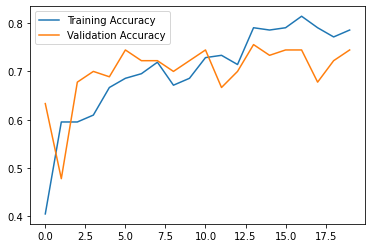

In [12]:
output_size = max(y_train) + 1
regularizer = tf.keras.regularizers.L1L2(l1=0, l2=0)

def build_cae(autoencoder, optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy']):
    encoder = Model(inputs=autoencoder.input, outputs=autoencoder.layers[-6].output, name='encoder')
    for encoding_layer in encoder.layers:
        encoding_layer.trainable = False
    input_shape = (encoder.output.shape[1], encoder.output.shape[2], encoder.output.shape[3])
    classifier = Sequential(name='classifier')
    classifier.add(tf.keras.layers.Input(shape=input_shape))
    classifier.add(tf.keras.layers.SpatialDropout2D(0.3))
    classifier.add(Flatten(name='dense_flatten'))
    classifier.add(Dropout(0.5))
    classifier.add(Dense(100, activation='relu', name='dense_400', kernel_regularizer=regularizer, bias_regularizer=regularizer, trainable=True))
    classifier.add(Dropout(0.5))
    classifier.add(Dense(100, activation='relu', name='dense_69', kernel_regularizer=regularizer, bias_regularizer=regularizer, trainable=True))
#     classifier.add(Dense(200, activation='relu', name='dense_666', kernel_regularizer=regularizer, bias_regularizer=regularizer, trainable=False))
#     classifier.add(Dense(200, activation='relu', name='dense_4', kernel_regularizer=regularizer, bias_regularizer=regularizer, trainable=False))
#     classifier.add(Dense(200, activation='relu', name='dense_6', kernel_regularizer=regularizer, bias_regularizer=regularizer, trainable=False))
    classifier.add(Dense(output_size, activation='softmax', name='softmax'))
    cae = Model(inputs=encoder.inputs, outputs=classifier(encoder.output), name='case')
#     cae.summary()
#     classifier.summary()
    cae.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    return cae

cae = build_cae(autoencoder)
cae.fit(x=X_train, 
        y=y_train,
        batch_size=32,
        epochs=20,
        validation_data=(X_val, y_val),
        callbacks=None,
        verbose=1)

plt.plot(cae.history.history['accuracy'], label='Training Accuracy')
plt.plot(cae.history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='upper left')

In [7]:
# classifier.compile(optimizer='adam',
#                    loss='sparse_categorical_crossentropy',
#                    metrics=['accuracy'])

# training_hist = classifier.fit(x=X_train, 
#                                y=y_train,
#                                batch_size=32,
#                                epochs=50,
#                                validation_data=(X_val, y_val),
#                                callbacks=None,
#                                verbose=1)

In [8]:
# timestamp = datetime.datetime.now().strftime("%Y-%m-%d-%H-%M")
# classifier_path = f'models/cae_{timestamp}_from_{latest_model_id}'
# classifier.save(classifier_path)
# print('Model saved')

In [9]:
# training_hist2 = classifier.fit(x=X_val, 
#                                y=y_val,
#                                batch_size=32,
#                                epochs=10,
#                                validation_data=(X_train, y_train),
#                                callbacks=None,
#                                verbose=1)

In [10]:
# training_hist3 = classifier.fit(x=X_val, 
#                                y=y_val,
#                                batch_size=32,
#                                epochs=10,
#                                validation_data=(X_val, y_val),
#                                callbacks=None,
#                                verbose=1)
